In [1]:
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

--2019-03-03 00:45:10--  https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
Resolving ceb.nlm.nih.gov (ceb.nlm.nih.gov)... 130.14.52.15, 2607:f220:41e:7052::15
Connecting to ceb.nlm.nih.gov (ceb.nlm.nih.gov)|130.14.52.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  20.7MB/s    in 16s     

2019-03-03 00:45:27 (21.1 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [0]:
!unzip -q cell_images.zip

In [0]:
mv cell_images training

In [0]:
!mkdir -p validation/Parasitized && mkdir -p validation/Uninfected

In [0]:
import numpy as np
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD

from keras.layers import Flatten, Dropout, BatchNormalization, Reshape, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import pandas as pd

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

import os
import shutil

import matplotlib.image as mpimg

In [0]:
training_parasitized_folder_name = "training/Parasitized"
training_uninfected_folder_name = "training/Uninfected"

validation_parasitized_folder_name = "validation/Parasitized"
validation_uninfected_folder_name = "validation/Uninfected"

parasitized_folder = os.listdir("training/Parasitized")
uninfected_folder = os.listdir("training/Uninfected")

total_images = 27558
validation_size = 0.20
validation_folder_size = int(len(parasitized_folder) * 0.20)

for image_name in parasitized_folder[:validation_folder_size]:
  image_url = f'{training_parasitized_folder_name}/{image_name}'
  shutil.move(image_url, validation_parasitized_folder_name)
  
for image_name in uninfected_folder[:validation_folder_size]:
  image_url = f'{training_uninfected_folder_name}/{image_name}'
  shutil.move(image_url, validation_uninfected_folder_name)

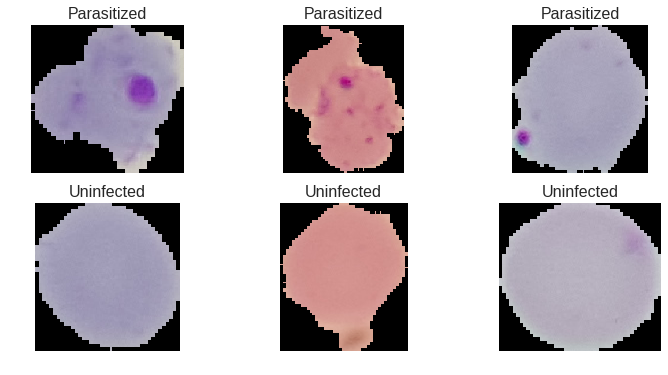

In [151]:
def plot_images(image_index, folder_name, image_name, title):
  sp = figure.add_subplot(2, 3, image_index + 1)
  sp.axis('Off')
  image_path = f'{folder_name}/{image_name}'
  image_loaded = img=mpimg.imread(image_path)
  sp.set_title(title, fontsize=16)
  plt.imshow(image_loaded, interpolation=None)

figure = plt.figure(figsize=(12, 6))
parasitized_images = os.listdir("training/Parasitized")[0:3]
uninfected_images = os.listdir("training/Uninfected")[0:3]

for image_index, image_name in enumerate(parasitized_images):
  plot_images(image_index, training_parasitized_folder_name, image_name, "Parasitized")

for image_index, image_name in enumerate(uninfected_images):
  plot_images(image_index + 3, training_uninfected_folder_name, image_name, "Uninfected")

In [0]:
batch_size = 32
img_size = 96
input_img_size = (96, 96, 3)
num_classes = 2

In [102]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest").flow_from_directory(
    "training",
    target_size=(img_size, img_size),
    color_mode="rgb",
	  shuffle=True,
    batch_size=batch_size)


val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(
    "validation",
    target_size=(img_size, img_size),
    color_mode="rgb",
	  shuffle=False,
    batch_size=batch_size)

Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [0]:
train_steps = int((total_images - (validation_folder_size * 2)) // batch_size)
val_steps = int((validation_folder_size * 2) // batch_size) 

## Model

In [0]:
def create_model():
  input_tensor = Input(shape=input_img_size)
  
  mobile_model = MobileNetV2(
       weights=None,
       input_tensor=input_tensor,
       input_shape=input_img_size,
       alpha=1.5,
       include_top=False)
  
  for layer in mobile_model.layers:
    layer.trainable = True
  
  mobile_model_output = mobile_model.output
  classification_layer = Flatten()(mobile_model_output)
  classification_layer = Dense(256, activation='relu')(classification_layer)
  classification_layer = Dropout(0.5)(classification_layer)
  predictions = Dense(activation="softmax", units=num_classes)(classification_layer)

  model = Model(inputs=input_tensor, outputs=predictions)
  
  return model

In [0]:
learning_rate = 3e-4
epochs = 30

In [0]:
def polynomial_decay(epoch):
	power = 1.0
 
	alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
	return alpha

In [13]:
weights_name = "epoch={epoch:02d}|accuracy={val_acc:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

optimizer = SGD(lr=learning_rate, momentum=0.9)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = create_model()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

In [36]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)

Epoch 1/30
688/688 [==============================] - 170s 248ms/step - loss: 0.5877 - acc: 0.6863 - val_loss: 0.5572 - val_acc: 0.7124

Epoch 00001: val_acc improved from 0.50967 to 0.71241, saving model to epoch=01|accuracy=0.7124.h5
Epoch 2/30
688/688 [==============================] - 155s 225ms/step - loss: 0.2535 - acc: 0.9068 - val_loss: 1.2090 - val_acc: 0.6255

Epoch 00002: val_acc did not improve from 0.71241
Epoch 3/30
688/688 [==============================] - 155s 225ms/step - loss: 0.1784 - acc: 0.9419 - val_loss: 0.4684 - val_acc: 0.7974

Epoch 00003: val_acc improved from 0.71241 to 0.79745, saving model to epoch=03|accuracy=0.7974.h5
Epoch 4/30
688/688 [==============================] - 155s 225ms/step - loss: 0.1623 - acc: 0.9480 - val_loss: 0.2689 - val_acc: 0.8896

Epoch 00004: val_acc improved from 0.79745 to 0.88960, saving model to epoch=04|accuracy=0.8896.h5
Epoch 5/30
688/688 [==============================] - 155s 225ms/step - loss: 0.1531 - acc: 0.9518 - val_

In [0]:
def plot_validation_training(metric, trained_model):
  validation_metric = trained_model.history[f'val_{metric}']
  training_metric = trained_model.history[metric]
  epochs = range(len(training_metric))
  plt.plot(epochs, training_metric, 'b', label=f'Training {metric}')
  plt.plot(epochs, validation_metric, 'r', label=f'Validation {metric}')
  plt.ylim(bottom=0)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel(metric, fontsize=16)
  loc = 'upper right' if metric == "loss" else 'lower right'
  plt.legend(loc=loc)
  plt.title(f'Training and validation {metric}', fontsize = 20)
  plt.show()

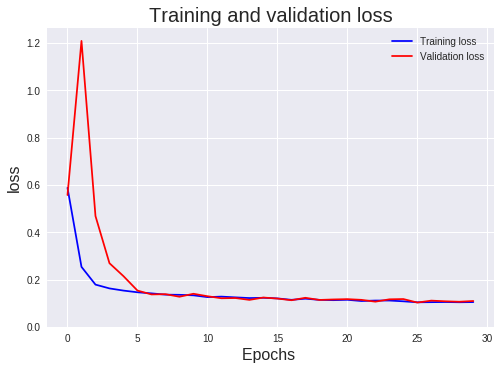

In [37]:
plot_validation_training("loss", trained_model)

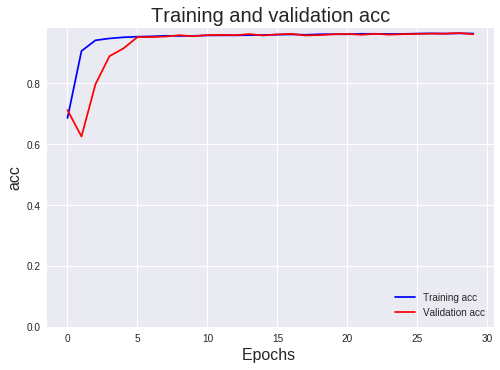

In [38]:
plot_validation_training("acc", trained_model)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
model.load_weights("epoch=29|accuracy=0.9659.h5")

In [0]:
val_generator.reset()

In [130]:
classes_predicted = model.predict_generator(val_generator, steps=val_steps, verbose=1)

172/172 [==============================] - 11s 62ms/step


In [131]:
len(classes_predicted)

5504

In [0]:
real_classes = np.argmax(classes_predicted, axis=1)

In [0]:
val_labels = val_generator.classes

In [0]:
val_labels = val_labels[:5504]

In [135]:
len(val_labels), len(real_classes)

(5504, 5504)

In [136]:
val_generator.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [0]:
classes_names = ["Parasitized", "Uninfected"]

Confusion matrix, without normalization
[[2638  118]
 [  82 2666]]


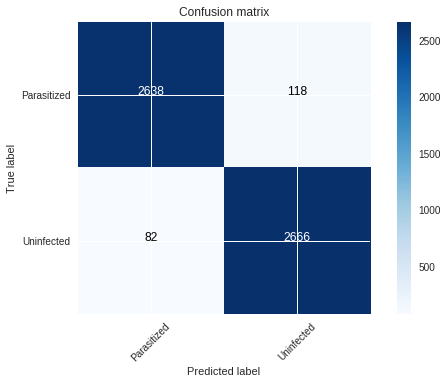

In [124]:
cm = confusion_matrix(val_labels, real_classes, labels=range(num_classes))
plot_confusion_matrix(cm, classes_names)

In [138]:
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f'sensitivity: {sensitivity}')

specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f'specifity: {specificity}')

sensitivity: 0.9571843251088534
specifity: 0.970160116448326


In [0]:
from sklearn.metrics import classification_report

In [127]:
report = classification_report(val_labels, real_classes, target_names=classes_names)
print(report)

              precision    recall  f1-score   support

 Parasitized       0.97      0.96      0.96      2756
  Uninfected       0.96      0.97      0.96      2748

   micro avg       0.96      0.96      0.96      5504
   macro avg       0.96      0.96      0.96      5504
weighted avg       0.96      0.96      0.96      5504



## Save model

In [0]:
model_json = model.to_json()
with open("malaria_model.json", "w") as json_file:
    json_file.write(model_json)